In [1]:
import matplotlib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import pandas as pd
import types
import os


from collections import OrderedDict
from slugify import slugify

# @TODO hide away hardcoded paths
font_regular = fm.FontProperties(fname=os.environ.get('ILLINOIS_GUNS_FONT_REGULAR')) 
font_medium = fm.FontProperties(fname=os.environ.get('ILLINOIS_GUNS_FONT_BOLD'))


matplotlib.rcParams['figure.figsize'] = (20, 6)
matplotlib.rcParams['font.size'] = 33
matplotlib.rcParams['hatch.linewidth'] = 1
matplotlib.rcParams['hatch.color'] = '#B95949'
matplotlib.rcParams['axes.labelsize'] = 13
matplotlib.rcParams['legend.fontsize'] = 13

%matplotlib inline


# Federal gun cases in Illinois Northern District

A tiny rig to generate graphics for Mick Dumke's follow up story to [HEADLINE TK](LINK TK).

Notes:

* Three cases filed prior to 2007 but later reopened were omitted. I used the only Pacer bulk-schema guide I could find to understand the fields. I also talked with Mike Lissner of the Free Law project, who pointed me to documentation at (https://free.law/pdf/PACER-API-Documentation.pdf, https://www.fjc.gov/research/idb).
* This counts defendants, not discrete cases. For example, if John Doe was charged with 18:924C.F and 18:922G.F in the same year, he would be reflected in both categories. (This is the fundamental difference between the `cs_caseid` column, which, when grouped, aggregates charges for a given defendant, and `cs_casenumber`, which represents a given party and charges brought against them).

# Setup

In [2]:
df = pd.read_csv('processed/federal-gun-cases.csv', parse_dates=[
    'cs_date_filed',
    'cs_date_term',
    'cs_date_reopen',
    'lead_date_term',
    'loc_date_end',
    'loc_date_start',
    'party_start_date',
    'party_end_date'])

We also need to synthesize some columns.

In [3]:
df['year_filed'] = df.cs_date_filed.dt.year.astype(int)
df['month_filed'] = df.cs_date_filed.dt.month.astype(int)
df['year_month_filed'] = df['cs_date_filed'].dt.strftime('%Y-%m')
df['defendant_case_id'] = df.apply(lambda row: slugify(str(row['cs_caseid']) + row['party']) + '-' + slugify(row['charges']), axis=1)

# 18:922G.F (felon in possession) as percent (single bar chart)

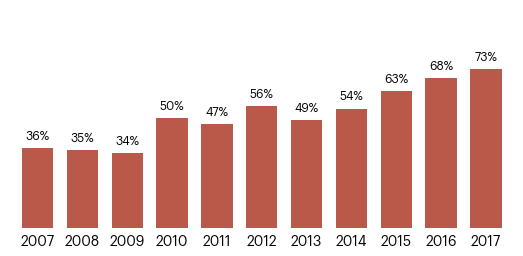

In [4]:
charges = '18:922G.F'
df['defendant_case_id'] = df.apply(lambda row: slugify(str(row['cs_caseid']) + row['party']) + '-' + slugify(row['charges']), axis=1)
all_grouped = df[df['year_filed'] > 2006].groupby(['year_filed'])['defendant_case_id'].agg(['count'])

filtered = df[(df['charges'] == '18:922G.F') & (df['year_filed'] > 2006)]
grouped = filtered.groupby(['year_filed'])['defendant_case_id'].agg(['count'])
grouped['pct'] = grouped['count']  / all_grouped['count'] * 100

ax = grouped.plot(y='pct', kind="bar", figsize=[9,4], legend=False, width=0.7, color=['#B95949'], fontsize=11)

ax.set_ylim(0, 100)

ax.yaxis.set_visible(False)

ax.xaxis.grid(False)

xvals = ax.get_xticks()
xlabels = [str(x) for x in range(2007, 2018)]
# xlabels[-1] = '{0}*'.format(xlabels[-1]) 
ax.set_xticklabels(xlabels, rotation=0, fontproperties=font_regular, fontsize=11)

ax.xaxis.label.set_visible(False)

for spine in plt.gca().spines.values():
    spine.set_visible(False)

rects = ax.patches

# Now make some labels
labels = []

for index, row in grouped.iterrows():
    labels.append('{0}'.format(int(row['pct'])))

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 3, '{0}%'.format(label), ha='center', va='bottom', color='black', fontsize=12, fontproperties=font_regular)


ax.tick_params(labelsize=14)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off'         # ticks along the top edge are off
)

plt.savefig('image/%s-pct.svg' % slugify(charges), transparent=True)

# Defendants per statute per year for most common charges (Grouped bar)

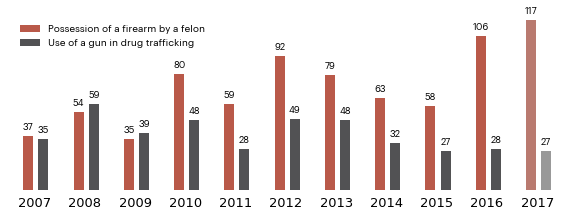

In [5]:
statutes = ['18:922G.F', '18:924C.F']
colors = ['#B95949', '#525254']
legend = ["Possession of a firearm by a felon", "Use of a gun in drug trafficking"]

filtered = df[(df['charges'].isin(statutes)) & (df['year_filed'] > 2006)]

pivoted = filtered.pivot_table(index=['year_filed'], columns=['charges'], values='defendant_case_id', aggfunc=lambda x: len(x.unique()))

ax = pivoted.plot(kind="bar", figsize=[10,3.2], width=0.6, color=colors, fontsize=14, rot=0)

ax.set_ylim(0, 120)
ax.yaxis.set_visible(False)

ax.xaxis.grid(False)

ax.xaxis.label.set_visible(False)

for spine in plt.gca().spines.values():
    spine.set_visible(False)

rects = ax.patches

# Now make some labels
labels = [str(value) for index, value in pivoted.unstack().iteritems()]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2.9, height + 3, label, ha='center', va='bottom', color='#000000', fontsize=9.5, fontproperties=font_regular)
    rect.set_width(0.2)
    
ax.tick_params(labelsize=13)

ax.legend(legend, prop=font_regular).get_frame().set_linewidth(0.0)

ax.patches[-12].set_facecolor('#B97A6F')
ax.patches[-1].set_facecolor('#999999')

for label in ax.xaxis.get_majorticklabels():
    label.customShiftValue = 0.075
    label.set_x = types.MethodType( lambda self, x: matplotlib.text.Text.set_x(self, x-self.customShiftValue ), 
                                    label, matplotlib.text.Text )

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off'         # ticks along the top edge are off
)

plt.savefig('image/grouped-bar.svg', transparent=True)

In [6]:
pivoted

charges,18:922G.F,18:924C.F
year_filed,,
2007,37,35
2008,54,59
2009,35,39
2010,80,48
2011,59,28
2012,92,49
2013,79,48
2014,63,32
2015,58,27


# Defendants per statute per month for most common charges (grouped bar)

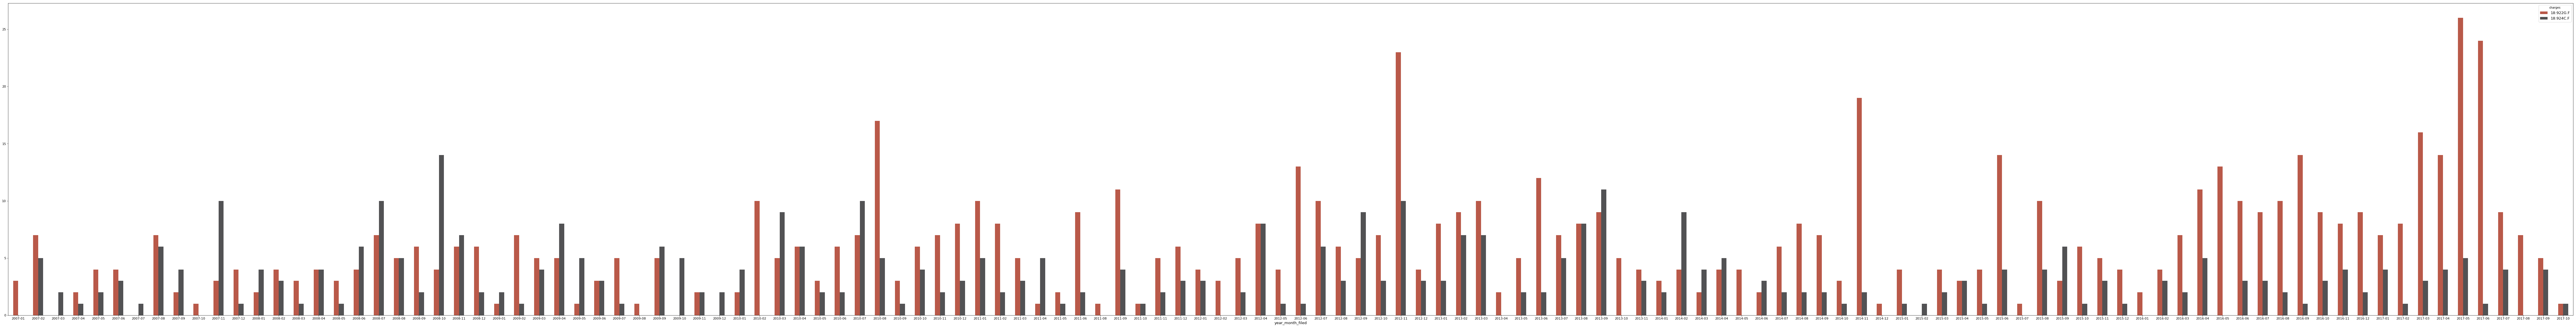

In [7]:
ym_pivoted = filtered.pivot_table(index=['year_month_filed'], columns=['charges'], values='defendant_case_id', aggfunc=lambda x: len(x.unique()))
ym_pivoted.plot(kind="bar", figsize=[160, 20], color=colors, fontsize=11, rot=0)

In [8]:
ym_pivoted

charges,18:922G.F,18:924C.F
year_month_filed,,
2007-01,3.0,NaN
2007-02,7.0,5.0
2007-03,NaN,2.0
2007-04,2.0,1.0
2007-05,4.0,2.0
2007-06,4.0,3.0
2007-07,NaN,1.0
2007-08,7.0,6.0
2007-09,2.0,4.0


# 3 ways of counting defendants

I did these counts three different ways to validate my methodology. The following section compares the three methods.

In [9]:
# validate later
methods = {'method1': [], 'method2': [], 'method3': []}

## Counting method #1 (caseid, party, charges)

            count        pct
year_filed                  
2007           35  34.653465
2008           59  39.072848
2009           39  38.235294
2010           48  30.379747
2011           28  22.580645
2012           49  29.878049
2013           48  30.188679
2014           32  27.826087
2015           27  29.347826
2016           28  18.181818
2017           27  16.875000
            count        pct
year_filed                  
2007           37  36.633663
2008           54  35.761589
2009           35  34.313725
2010           80  50.632911
2011           59  47.580645
2012           92  56.097561
2013           79  49.685535
2014           63  54.782609
2015           58  63.043478
2016          106  68.831169
2017          117  73.125000


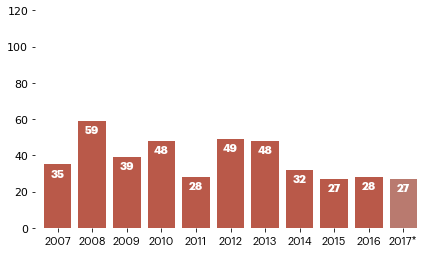

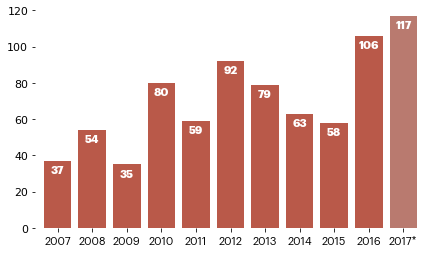

In [10]:
df['defendant_case_id'] = df.apply(lambda row: slugify(str(row['cs_caseid']) + row['party']) + '-' + slugify(row['charges']), axis=1)

all_grouped = df[df['year_filed'] > 2006].groupby(['year_filed'])['defendant_case_id'].agg(['count'])
for charge in ['18:924C.F', '18:922G.F']:
    filtered = df[(df['charges'] == charge) & (df['year_filed'] > 2006)]
    grouped = filtered.groupby(['year_filed'])['defendant_case_id'].agg(['count'])
    grouped['pct'] = grouped['count']  / all_grouped['count'] * 100
    
    methods['method1'].append(grouped)
    
    ax = grouped.plot(y='count', kind="bar", figsize=[7,4], legend=False, width=0.8, color=['#B95949'], fontsize=11)
        
    ax.set_ylim(0, 120)
    yvals = ax.get_yticks()
      
    ax.xaxis.grid(False)
    
    xvals = ax.get_xticks()
    xlabels = [str(x) for x in range(2007, 2018)]
    xlabels[-1] = '{0}*'.format(xlabels[-1]) 
    ax.set_xticklabels(xlabels, rotation=0, fontproperties=font_regular, fontsize=11)
        
    ax.xaxis.label.set_visible(False)
                
    for spine in plt.gca().spines.values():
        spine.set_visible(False)

    rects = ax.patches

    # Now make some labels
    labels = []

    for index, row in grouped.iterrows():
        labels.append('{0}'.format(int(row['count']), row['pct']))
    
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height - 8, label, ha='center', va='bottom', color='white', fontsize=11, fontproperties=font_medium)

        
    ax.tick_params(labelsize=11)
    
    ax.patches[-1].set_facecolor('#B97A6F')

    print(grouped)

## Counting method #2 (case id + party)

            count        pct
year_filed                  
2007           35  34.653465
2008           59  39.072848
2009           39  38.235294
2010           48  30.379747
2011           28  22.580645
2012           49  29.878049
2013           48  30.188679
2014           32  27.826087
2015           27  29.347826
2016           28  18.181818
2017           27  16.875000
            count        pct
year_filed                  
2007           37  36.633663
2008           54  35.761589
2009           35  34.313725
2010           80  50.632911
2011           59  47.580645
2012           92  56.097561
2013           79  49.685535
2014           63  54.782609
2015           58  63.043478
2016          106  68.831169
2017          117  73.125000


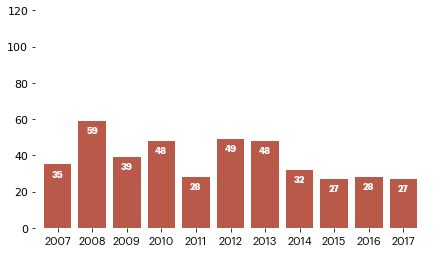

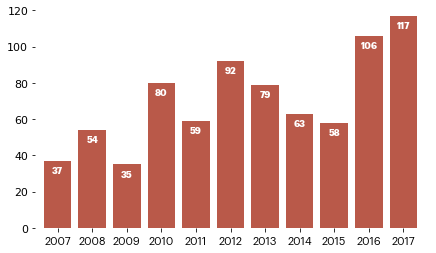

In [11]:
df['defendant_case_id'] = df.apply(lambda row: slugify(str(row['cs_caseid'])) + '-' + slugify(row['charges']), axis=1)

all_grouped = df[df['year_filed'] > 2006].groupby(['year_filed'])['defendant_case_id'].agg(['count'])
for charge in ['18:924C.F', '18:922G.F']:
    filtered = df[(df['charges'] == charge) & (df['year_filed'] > 2006)]
    grouped = filtered.groupby(['year_filed'])['defendant_case_id'].agg(['count'])
    grouped['pct'] = grouped['count']  / all_grouped['count'] * 100
    
    methods['method2'].append(grouped)

    
    ax = grouped.plot(y='count', kind="bar", figsize=[7,4], legend=False, width=0.8, color=['#B95949'], fontsize=11)
        
    ax.set_ylim(0, 120)
    yvals = ax.get_yticks()
      
    ax.xaxis.grid(False)
    
    xvals = ax.get_xticks()
    ax.set_xticklabels([str(x) for x in range(2007, 2018)], rotation=0, fontproperties=font_regular, fontsize=11)
        
    ax.xaxis.label.set_visible(False)
                
    for spine in plt.gca().spines.values():
        spine.set_visible(False)

    rects = ax.patches

    # Now make some labels
    labels = []

    for index, row in grouped.iterrows():
        labels.append('{0}'.format(int(row['count']), row['pct']))
    
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height - 8, label, ha='center', va='bottom', color='white', fontsize=9, fontproperties=font_medium)

    ax.tick_params(labelsize=11)

    print(grouped)

## Counting method #3 (just case number, which _should_ refer to unique defendants)

            count        pct
year_filed                  
2007           35  34.653465
2008           59  39.072848
2009           39  38.235294
2010           48  30.379747
2011           28  22.580645
2012           49  29.878049
2013           48  30.188679
2014           32  27.826087
2015           27  29.347826
2016           28  18.181818
2017           27  16.875000
            count        pct
year_filed                  
2007           37  36.633663
2008           54  35.761589
2009           35  34.313725
2010           80  50.632911
2011           59  47.580645
2012           92  56.097561
2013           79  49.685535
2014           63  54.782609
2015           58  63.043478
2016          106  68.831169
2017          117  73.125000


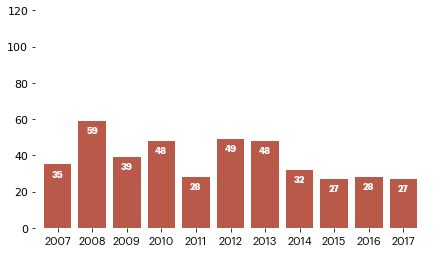

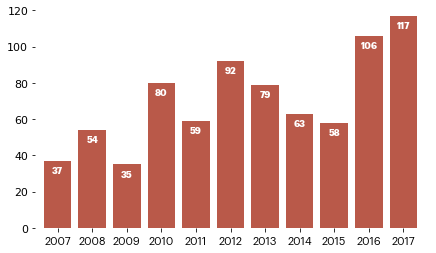

In [12]:
df['defendant_case_id'] = df.apply(lambda row: slugify(str(row['cs_case_number'])), axis=1)

all_grouped = df[df['year_filed'] > 2006].groupby(['year_filed'])['defendant_case_id'].agg(['count'])
for charge in ['18:924C.F', '18:922G.F']:
    filtered = df[(df['charges'] == charge) & (df['year_filed'] > 2006)]
    grouped = filtered.groupby(['year_filed'])['defendant_case_id'].agg(['count'])
    grouped['pct'] = grouped['count']  / all_grouped['count'] * 100
    methods['method3'].append(grouped)

    ax = grouped.plot(y='count', kind="bar", figsize=[7,4], legend=False, width=0.8, color=['#B95949'], fontsize=11)
        
    ax.set_ylim(0, 120)
    yvals = ax.get_yticks()
      
    ax.xaxis.grid(False)
    
    xvals = ax.get_xticks()
    ax.set_xticklabels([str(x) for x in range(2007, 2018)], rotation=0, fontproperties=font_regular, fontsize=11)
        
    ax.xaxis.label.set_visible(False)
                
    for spine in plt.gca().spines.values():
        spine.set_visible(False)

    rects = ax.patches

    # Now make some labels
    labels = []

    for index, row in grouped.iterrows():
        labels.append('{0}'.format(int(row['count']), row['pct']))
    
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height - 8, label, ha='center', va='bottom', color='white', fontsize=9, fontproperties=font_medium)

    ax.tick_params(labelsize=11)
    print(grouped)

# Validate counting methods

In [13]:
methods['method1'][0] == methods['method2'][0]

,count,pct
year_filed,,
2007,True,True
2008,True,True
2009,True,True
2010,True,True
2011,True,True
2012,True,True
2013,True,True
2014,True,True
2015,True,True


In [14]:
methods['method2'][0] == methods['method3'][0]

,count,pct
year_filed,,
2007,True,True
2008,True,True
2009,True,True
2010,True,True
2011,True,True
2012,True,True
2013,True,True
2014,True,True
2015,True,True


In [15]:
methods['method1'][1] == methods['method2'][1]

,count,pct
year_filed,,
2007,True,True
2008,True,True
2009,True,True
2010,True,True
2011,True,True
2012,True,True
2013,True,True
2014,True,True
2015,True,True


In [16]:
methods['method2'][1] == methods['method3'][1]

,count,pct
year_filed,,
2007,True,True
2008,True,True
2009,True,True
2010,True,True
2011,True,True
2012,True,True
2013,True,True
2014,True,True
2015,True,True
